In [1]:
import warnings
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec# Create 2x2 sub plots
import cftime
from matplotlib.dates import DateFormatter
from matplotlib import colorbar, colors
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

# Load Data

In [29]:
fn_url = 'https://www.psl.noaa.gov/thredds/dodsC/Datasets'
var_url = ['/ncep.reanalysis.derived/surface_gauss/uwnd10m.mon.mean.nc','/ncep.reanalysis.derived/surface_gauss/vwnd10m.mon.mean.nc',
          '/ncep.reanalysis2.derived/surface/mslp.mon.mean.nc','noaa.ersst.v5/sst.mnmean.nc', '/prec/precip.mon.anom.nc']
var_url;

In [30]:
files_url = [f'{fn_url}{x}' for x in var_url]
files_url;

In [4]:
da_wind= xr.open_mfdataset(files_url[0:2])
da_slp= xr.open_dataset(files_url[2])
da_sst= xr.open_dataset(files_url[3])
da_pr= xr.open_dataset(files_url[4])

#Select year 1979-2020
da_sst = da_sst.sel(time=slice("1979", "2020")).load() 
da_pr = da_pr.sel(time=slice("1979", "2020")).load()
da_wind = da_wind.sel(time=slice("1979", "2020")).load()

In [31]:
#View your data arrays
da_wind
da_slp
da_sst
da_pr;

In [6]:
da = da_slp.copy() #DataArray to combine all variables

#Regridding datasets to similar grid resolution (slp-grid type)
da['sst'] = (da_sst.interp_like(da.mslp)).sst  
da_pr = (da_pr.interp_like(da.mslp)).load()
da_wind = (da_wind.interp_like(da.mslp)).load()
da['uwnd'] = da_wind.uwnd
da['vwnd'] = da_wind.vwnd
#da['precip'] = da_pr.precip #Precipitation is an anomaly data. It will be inlcluded later

In [32]:
# Datasets
da;

**Calculate climatology and monthly anomalies for all variables**

In [8]:
#Climatology
da_clim = da.groupby('time.month').mean(dim='time')
#Anomalies
da_ano = da.groupby('time.month') - da_clim

In [33]:
da_ano['precip']=da_pr.precip; #Include the precipitation anomalies in the central dataset
da_ano = (da_ano.reset_coords(names=['month'], drop=True)).load() 
da_ano;

ValueError: One or more of the specified variables cannot be found in this dataset

# **El Niño-Southern Oscillation (ENSO)**

The El Niño-Southern Oscillation (ENSO) is a recurring climate pattern that involves fluctuating ocean temperatures in the central and eastern equatorial Pacific, coupled with changes in the atmosphere. It fluctuates between three phases: Neutral, La Niña (cold) or El Niño (warm). ENSO affects the distribution of rainfall in the tropics and can strongly modifies weather conditions in various part of the world. 

Here, we will calculate the ENSO index using Nino3.4 region (*5N-5S, 170W - 120W*) and Emperical Orthogonal Function(EOFs) of the tropical pacific. Thereafter, we will perform correlation between the two time series. Lastly, we will also connsider the DJF analysis since ENSO occurs during the boreal winter season

[Learn more about ENSO](https://iridl.ldeo.columbia.edu/maproom/ENSO/ENSO_Info.html "What is ENSO?")


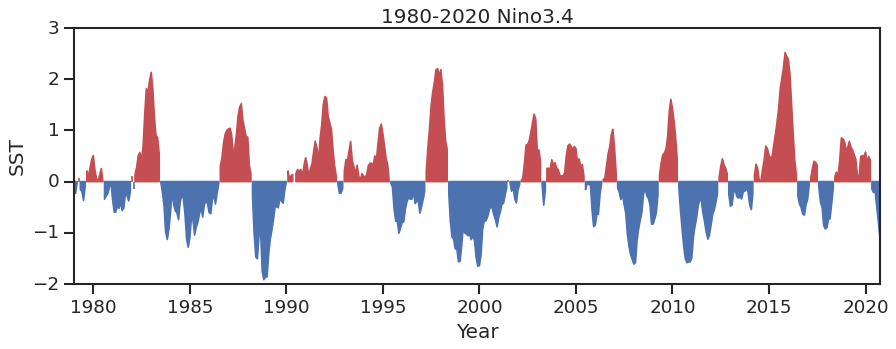

In [13]:
#Calculate the Nino 3.4 index
da_sst_reg=(da_ano.sst.sel(lon=slice(190,240), lat=slice(5,-5))).mean(dim=['lon','lat'])
sns.set(style="ticks", context="talk")
#plt.style.use("classic")
plt.figure(figsize=(13,4))
plt.fill_between(da_sst_reg.time.values, 0, da_sst_reg, where= da_sst_reg>0, facecolor='r', edgecolor='r')
plt.fill_between(da_sst_reg.time.values, 0, da_sst_reg, where= da_sst_reg<0, facecolor='b', edgecolor='b')
#sns.despine(offset=10)
plt.title('1980-2020 Nino3.4')
plt.ylabel('SST')
plt.xlabel('Year');

**EOF Method**

In [14]:
da_trop_reg=(da_ano.sst.sel(lon=slice(100,310), lat=slice(20,-20))) #Select the region
solver = Eof(da_trop_reg) #Eof package
eof1 = solver.eofsAsCovariance(neofs=1) # Select the first mode
pc1 = solver.pcs(npcs=1, pcscaling=1)
variance_fractions = solver.varianceFraction(neigs=1)

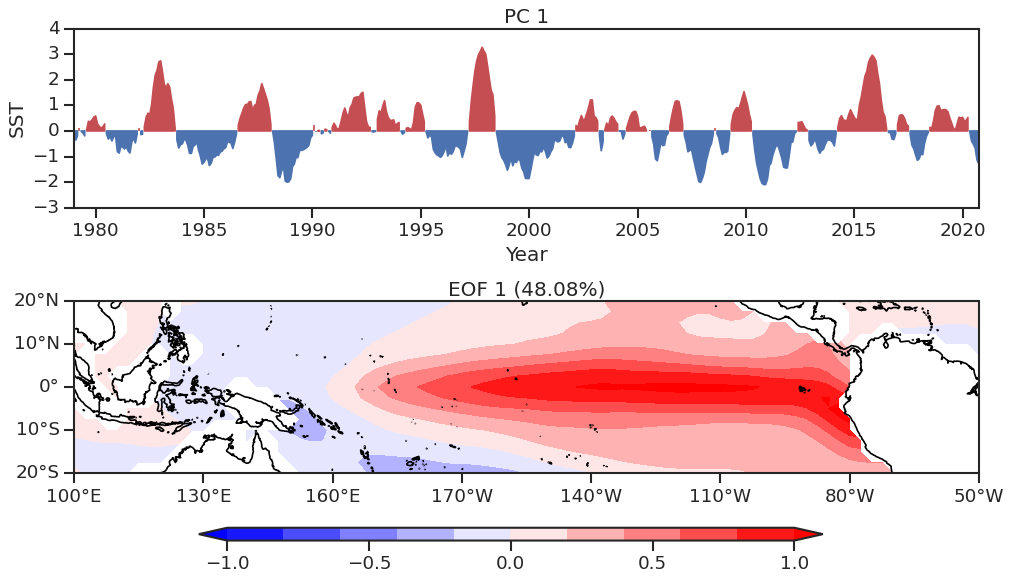

In [15]:
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(2,1,2, projection = ccrs.PlateCarree(180))
clevs = np.arange(-1,1.2,0.2)
cs=ax.contourf(da_trop_reg.lon,da_trop_reg.lat,eof1.isel(mode=0),clevs,transform = ccrs.PlateCarree(),cmap='bwr',extend='both')
ax.coastlines()
ax.set_yticks(np.arange(-20,30,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xticks(np.arange(100,330,30), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_title('EOF 1' + ' (' +  "{:05.2f}".format(variance_fractions.values[0]*100) +'%)' )
cbar_ax = fig.add_axes([0.2, 0.10, 0.6, 0.02])
fig.colorbar(cs,cax=cbar_ax, shrink=0.65, orientation='horizontal', ticks=np.arange(-1,1.5,0.5))

ax = fig.add_subplot(2, 1, 1)
ax.fill_between(da_sst_reg.time.values, 0, pc1.isel(mode=0), where= pc1.isel(mode=0)>0, facecolor='r', edgecolor='r')
ax.fill_between(da_sst_reg.time.values, 0, pc1.isel(mode=0), where= pc1.isel(mode=0)<0, facecolor='b', edgecolor='b');
ax.set_title('PC 1')
ax.set_ylabel('SST')
ax.set_xlabel('Year');

fig.subplots_adjust(bottom=0.2, top=0.9, left=0.08, right=0.95, wspace=0.05, hspace=0.5);


Now let's compute the correlation between Nino 3.4 region time series and PC1 index

In [19]:
#Correlation between box averaged Nino3.4 region and PC1
cr_nino_pc = xr.corr(da_sst_reg, pc1)
print("The correlation of box averaged Nino3.4 and PC1 is :", "{:04.2f}".format(cr_nino_pc.values))

The correlation of box averaged Nino3.4 and PC1 is : 0.96


## Now let's focus on boreal winter season (DJF) and repeat previous analysis

In [34]:
#DJF computation

da_ano_djf = da_ano.sel(time=(da_ano['time.season'] == 'DJF'))
da_ano_djf;

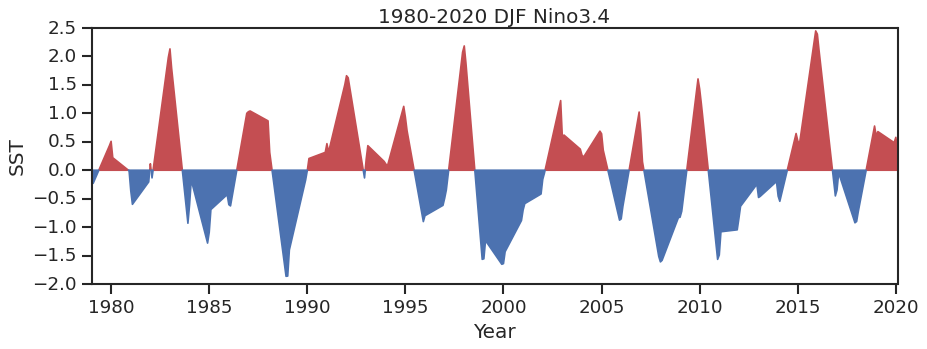

In [22]:
da_sst_reg_djf=(da_ano_djf.sst.sel(lon=slice(190,240), lat=slice(5,-5))).mean(dim=['lon','lat'])

sns.set(style="ticks", context="talk")
#plt.style.use("classic")
plt.figure(figsize=(13,4))
plt.fill_between(da_sst_reg_djf.time.values, 0, da_sst_reg_djf, where= da_sst_reg_djf>0, facecolor='r', edgecolor='r',interpolate=True)
plt.fill_between(da_sst_reg_djf.time.values, 0, da_sst_reg_djf, where= da_sst_reg_djf<0, facecolor='b', edgecolor='b', interpolate=True)
#sns.despine(offset=10)
plt.title('1980-2020 DJF Nino3.4')
plt.ylabel('SST')
plt.xlabel('Year');

In [23]:
#EOF

da_trop_reg_djf=(da_ano_djf.sst.sel(lon=slice(100,310), lat=slice(20,-20)))
solver = Eof(da_trop_reg_djf)
eof1 = solver.eofsAsCovariance(neofs=1)
pc1 = solver.pcs(npcs=1, pcscaling=1)
variance_fractions = solver.varianceFraction(neigs=1)

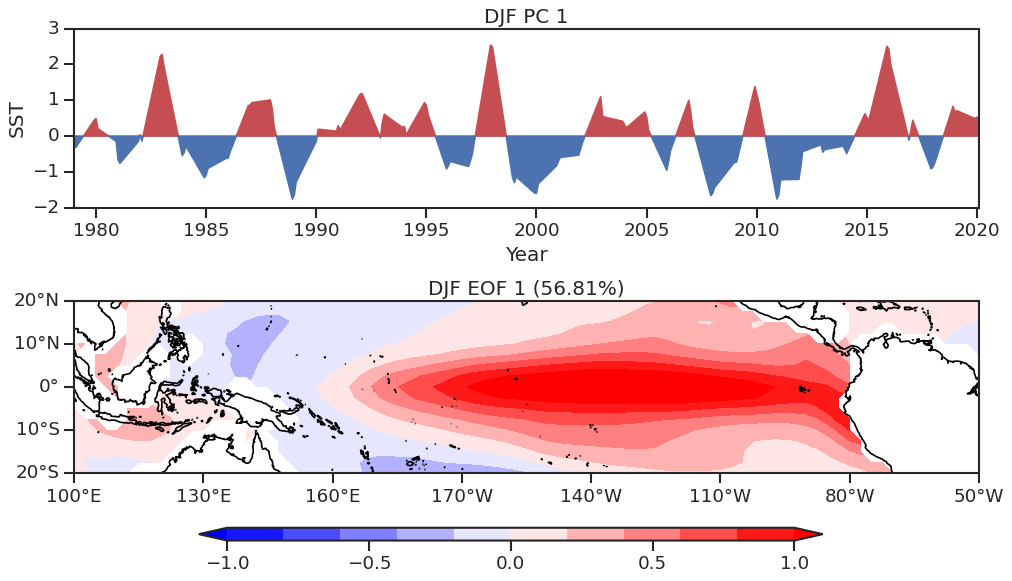

In [24]:
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(2,1,2, projection = ccrs.PlateCarree(180))
clevs = np.arange(-1,1.2,0.2)
cs=ax.contourf(da_trop_reg_djf.lon,da_trop_reg_djf.lat,eof1.isel(mode=0),clevs,transform = ccrs.PlateCarree(),cmap='bwr',extend='both')
ax.coastlines()
ax.set_yticks(np.arange(-20,30,10), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xticks(np.arange(100,330,30), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_title('DJF EOF 1' + ' (' +  "{:05.2f}".format(variance_fractions.values[0]*100) +'%)' )
cbar_ax = fig.add_axes([0.2, 0.10, 0.6, 0.02])
fig.colorbar(cs,cax=cbar_ax, shrink=0.65, orientation='horizontal', ticks=np.arange(-1,1.5,0.5))

ax = fig.add_subplot(2, 1, 1)
ax.fill_between(da_trop_reg_djf.time.values, 0, pc1.isel(mode=0), where= pc1.isel(mode=0)>0, facecolor='r', edgecolor='r',interpolate=True)
ax.fill_between(da_trop_reg_djf.time.values, 0, pc1.isel(mode=0), where= pc1.isel(mode=0)<0, facecolor='b', edgecolor='b',interpolate=True);
ax.set_title('DJF PC 1')
ax.set_ylabel('SST')
ax.set_xlabel('Year');

fig.subplots_adjust(bottom=0.2, top=0.9, left=0.08, right=0.95, wspace=0.05, hspace=0.5);


In [27]:
cr_nino_pc_djf = xr.corr(da_sst_reg_djf, pc1)
print("The DJF correlation of box averaged Nino3.4 and PC1 is :",  "{:04.2f}".format(cr_nino_pc_djf.values))

The DJF correlation of box averaged Nino3.4 and PC1 is : 0.99


# ENSO Teleconnections - Global precipitation impacts during ENSO events
Changes in the atmosphere in one location can affect normal weather conditions in many parts of the world. ENSO effects are called teleconnecions. Now let's use regression analysis to show the amount of precipitation changes in parts of the globe during ENSO events

## Regression of  precipitation anomalies on Nino3.4

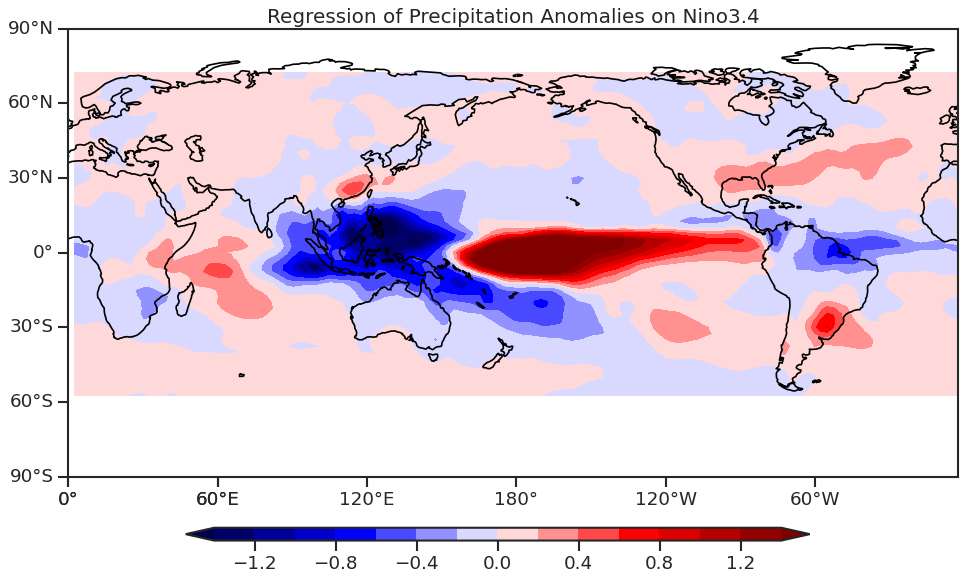

In [28]:
#Regression

xr_cov = xr.cov(da_sst_reg,da_ano.precip,  dim='time');
xr_var = da_sst_reg.var(dim='time')
reg_coeff = xr_cov/xr_var

fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree(180))
clevs = np.arange(-1.4,1.6,0.2)
cs=ax.contourf(da_ano.lon,da_ano.lat,reg_coeff,clevs,transform = ccrs.PlateCarree(),cmap='seismic',extend='both')
ax.coastlines()
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_xticks(np.arange(0,422,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_title('Regression of Precipitation Anomalies on Nino3.4' )
cbar_ax = fig.add_axes([0.2, 0.10, 0.6, 0.02])
fig.colorbar(cs,cax=cbar_ax, shrink=0.65, orientation='horizontal');
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.08, right=0.95, wspace=0.05, hspace=0.5);


![title](https://www.weather.gov/images/fwd/climate/enso/ElNino.png)

